In [29]:
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter, freqz, filtfilt

plt.rcParams['font.family'] = 'Palatino Linotype'
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = [8,6]
plt.rcParams['legend.loc'] = 'best'

# The envelope detector implemented using the Hilbert transform
# See: https://blog.csdn.net/m0_37262671/article/details/125303404
def get_envelope(x, n=None):
    analytic_signal = hilbert(x, N=n)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope

def butter_lowpass(cutoff_frequency, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff_frequency, fs, order=4):
    b, a = butter_lowpass(cutoff_frequency, fs, order=order)
    y = lfilter(b, a, data)
    return y  

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# produce AWGN noise
def awgn(x, snr_dB): # SNR in dB
    snr = 10**(snr_dB/10.0)
    xpower = np.sum(x**2)/len(x)    # power of input signal
    npower = xpower / snr        # power of noise calculated by SNR
    # gaussian noise
    noise = np.random.randn(len(x)) * np.sqrt(npower)
    return noise, npower

## Generate FM Signal

In [14]:
from scipy.signal import butter, lfilter, freqz, hilbert
# generate message from wav
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift
from scipy.io import wavfile
from scipy import signal

kf = 0.3    # modulation index
fc = 1e4    # carrier frequency
bw = 4e3    # required baseband bandwidth

fs, orig_data = wavfile.read('audio.wav')
# message is the normalized audio signal
message = butter_lowpass_filter(orig_data / np.max(np.abs(orig_data)), bw, fs, order=8)
t = np.arange(0, len(message)/fs, 1/fs)  # Time vector

# calculate frequency deviation
deviation = kf*max(message)

# 2. Perform Frequency Modulation (FM)
integral_of_message = np.cumsum(message) / fs
fm_signal = np.cos(2 * np.pi * fc * t + 2 * np.pi * deviation * integral_of_message)
fm_signal_spectrum = fftshift(fft(fm_signal))
freqs = np.linspace(-fs/2, fs/2, len(fm_signal_spectrum))


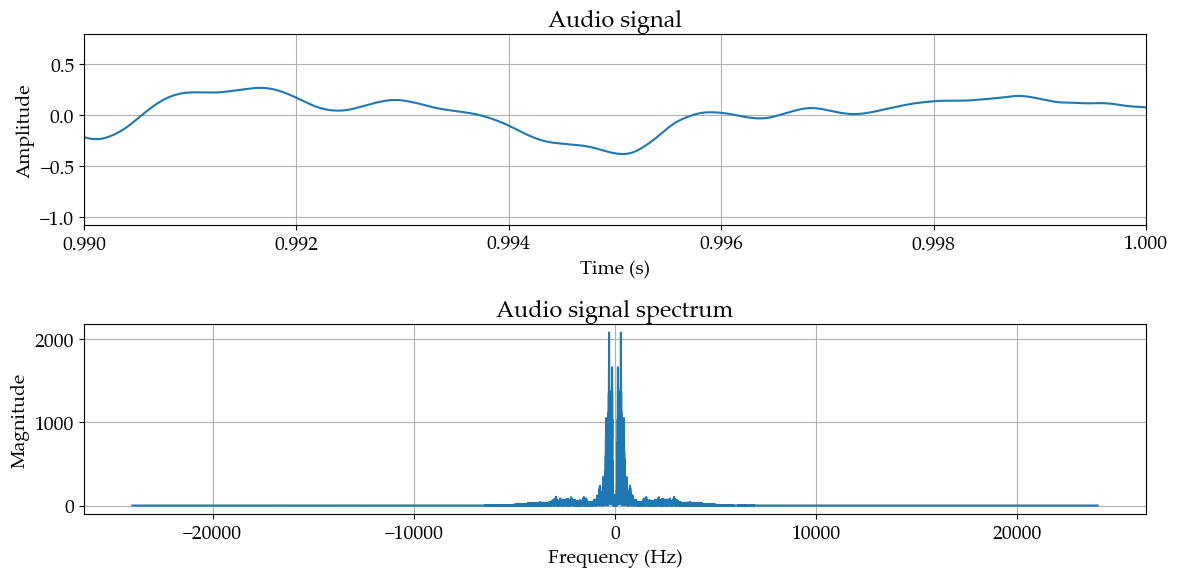

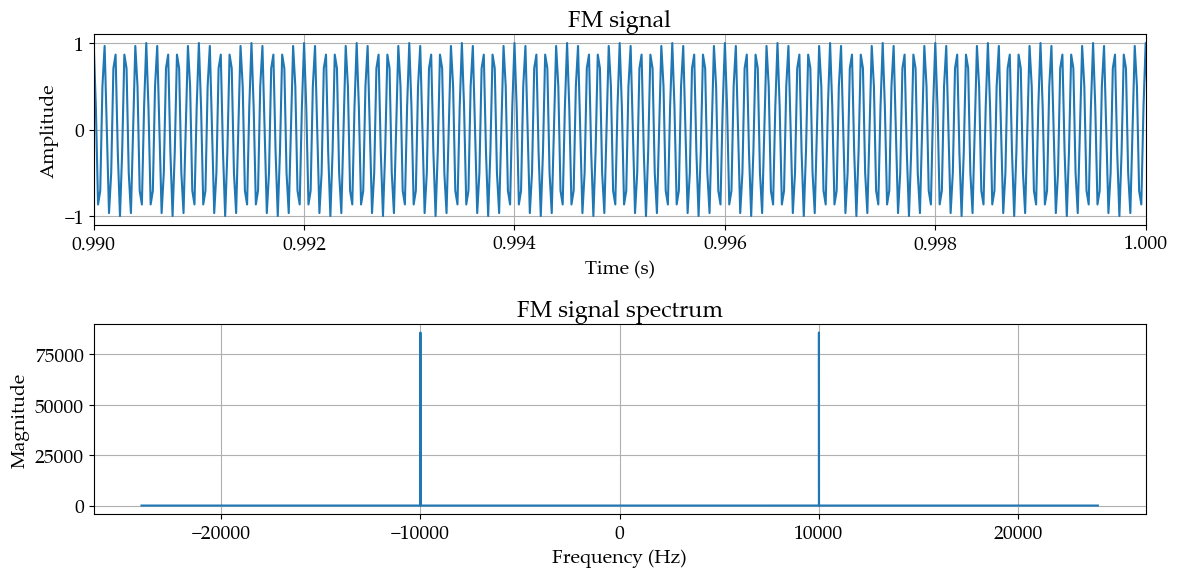

In [53]:
# plot audio signal and its fft
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, message)
plt.title('Audio signal')
plt.xlabel('Time (s)')
plt.xlim(0.99, 1)
plt.ylabel('Amplitude')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(freqs, np.abs(fftshift(fft(message))))
plt.title('Audio signal spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.tight_layout()
plt.show()


# plot fm signal and its fft
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, fm_signal)
plt.title('FM signal')
plt.xlabel('Time (s)')
plt.xlim(0.99, 1)
plt.ylabel('Amplitude')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(freqs, np.abs(fm_signal_spectrum))
plt.title('FM signal spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.tight_layout()
plt.show()


## Add Noise

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


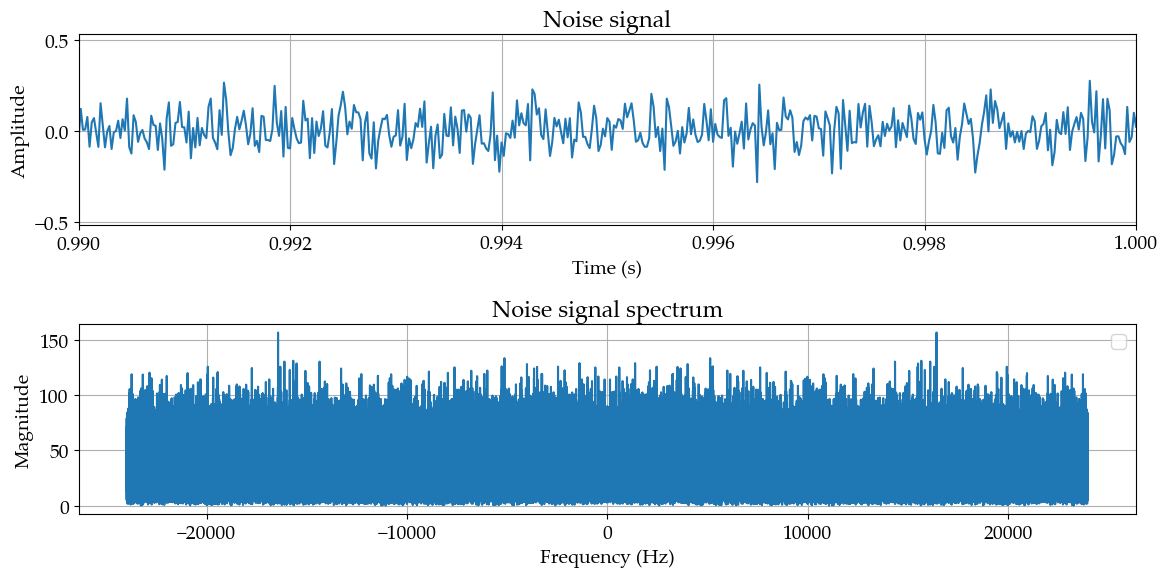

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


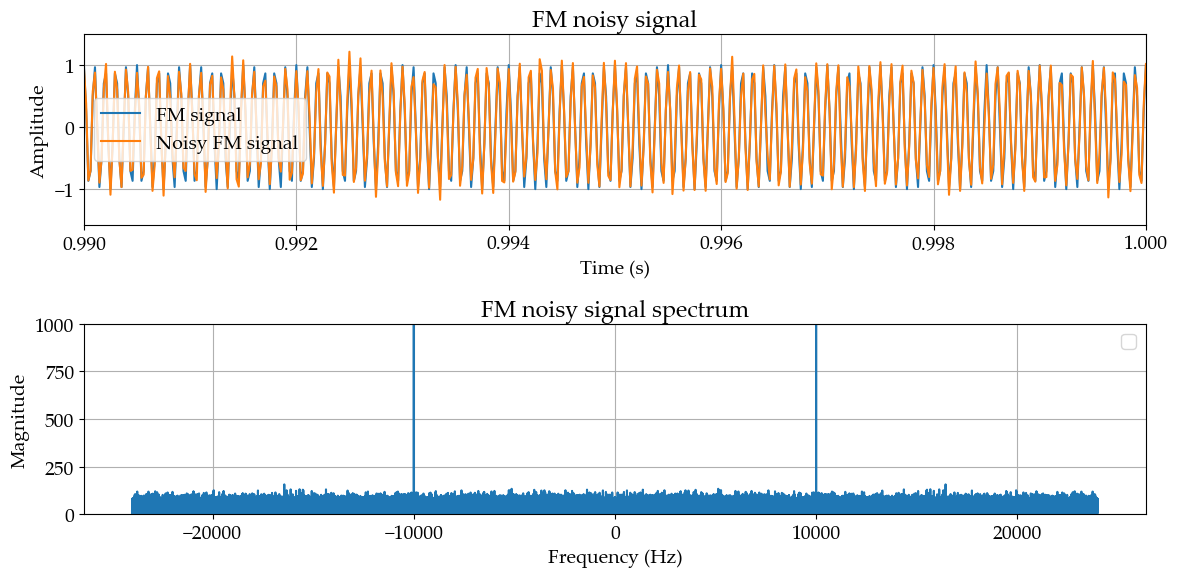

In [22]:
# 3. Add AWGN Noise
noise_power = 0.01  # Noise power
noise = np.sqrt(noise_power) * np.random.normal(size=len(t))
fm_noisy_signal = fm_signal + noise

# plot noise signal and its fft
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, noise)
plt.title('Noise signal')
plt.xlabel('Time (s)')
plt.xlim(0.99, 1)
plt.ylabel('Amplitude')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(freqs, np.abs(fftshift(fft(noise))))
plt.title('Noise signal spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

# plot fm noisy signal and its fft
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, fm_signal, label='FM signal')
plt.plot(t, fm_noisy_signal, label='Noisy FM signal')
plt.title('FM noisy signal')
plt.xlabel('Time (s)')
plt.xlim(0.99, 1)
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(freqs, np.abs(fftshift(fft(fm_noisy_signal))))
plt.title('FM noisy signal spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.ylim(0, 1000)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()


## Demodulation

In [23]:
# 4. Frequency Demodulation
# For simplicity, using the derivative of the phase of the analytical signal
analytic_signal = hilbert(fm_noisy_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = np.diff(instantaneous_phase) * (fs / (2.0 * np.pi)) #!!!Should simulate the slope filter?
demodulated_signal = np.insert(instantaneous_frequency, 0, 0)  # Add a value for t=0

# Low-pass filter for demodulated signal (for post-detection)
b, a = butter(5, 2 * bw / fs, 'low')  # Low-pass filter with a cutoff at 50 Hz
filtered_demodulated_signal = filtfilt(b, a, demodulated_signal)



Text(0, 0.5, 'Magnitude')

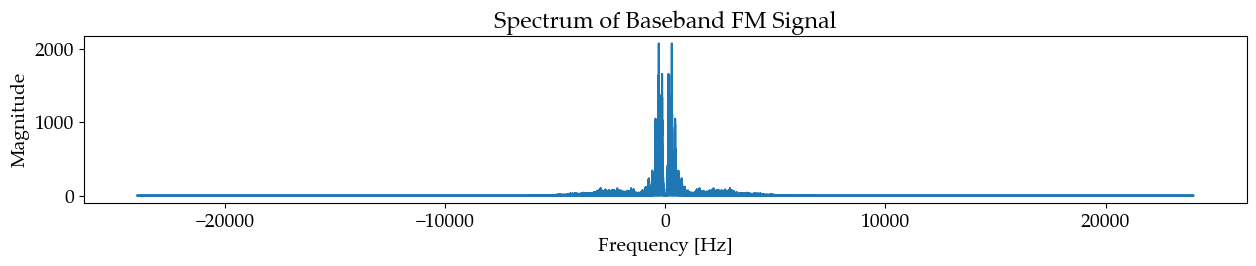

In [26]:
# 5. Plots
plt.figure(figsize=(15, 10))

# generate f for baseband_fm_spectrum
f = np.fft.fftfreq(len(message), 1/fs)

# Spectrum of the baseband FM signal
plt.subplot(4, 1, 1)
baseband_fm_spectrum = fft(message)
# baseband_fm_spectrum = fftshift(fft(message))
plt.plot(f, np.abs(baseband_fm_spectrum))
plt.title('Spectrum of Baseband FM Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')


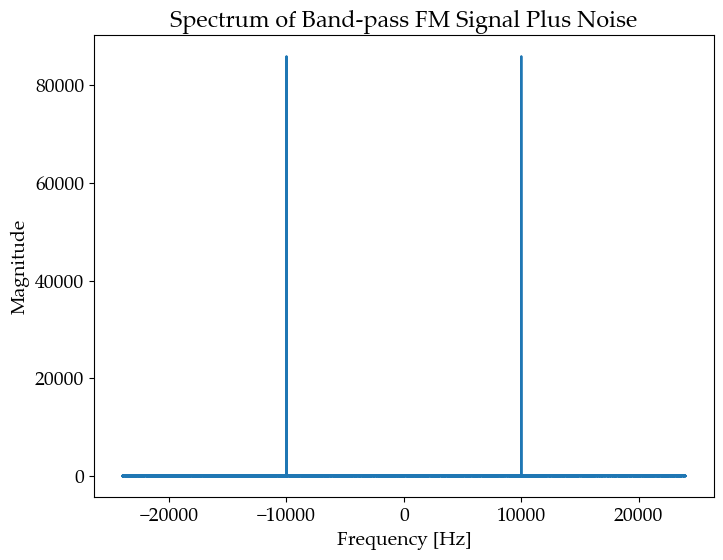

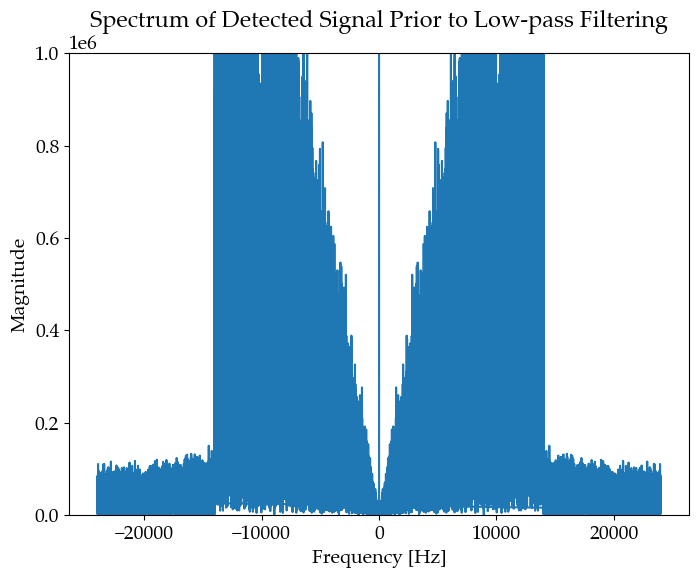

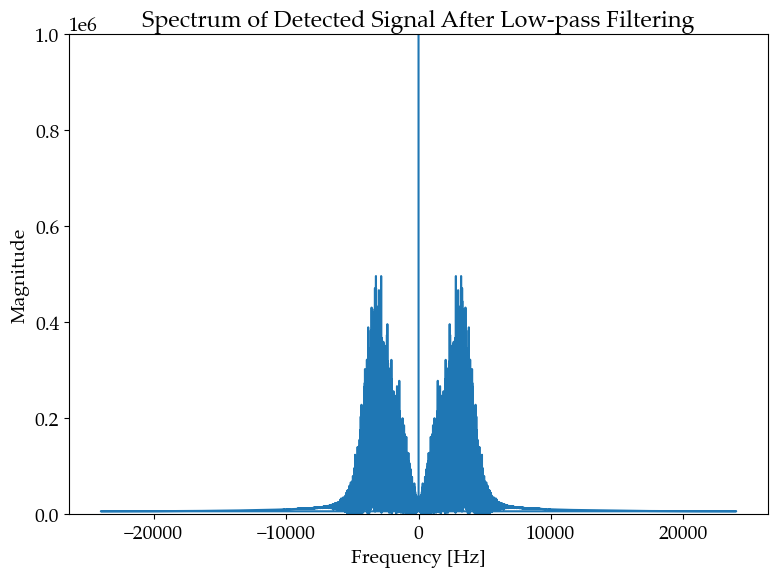

(array([ 1.        ,  0.25881905, -0.8660254 , ..., -0.70702626,
        -0.86608233,  0.25870906]),
 array([ 0.79646134,  0.27741355, -0.861532  , ..., -0.73585425,
        -0.75396764,  0.21351474]),
 array([    0.        ,  9584.96918015, 10103.32089945, ...,
         9867.58543655, 10100.50464117, 10314.50348007]),
 array([4.40667391e+00, 3.36366053e+03, 6.37780359e+03, ...,
        1.00637337e+04, 1.01792012e+04, 1.03081723e+04]))

In [36]:
# Spectrum of the band-pass FM signal plus noise
plt.figure()
bandpass_fm_spectrum = fft(fm_noisy_signal)
plt.plot(f, np.abs(bandpass_fm_spectrum))
plt.title('Spectrum of Band-pass FM Signal Plus Noise')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.show()
# Spectrum of the detected signal prior to low-pass filtering
plt.figure()
detected_spectrum_pre_filter = fft(demodulated_signal)
plt.plot(f, np.abs(detected_spectrum_pre_filter))
plt.title('Spectrum of Detected Signal Prior to Low-pass Filtering')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.ylim(0, 1000000)
plt.show()
# Spectrum of the detected signal after low-pass filtering
plt.figure()
detected_spectrum_post_filter = fft(filtered_demodulated_signal)
plt.plot(f, np.abs(detected_spectrum_post_filter))
plt.title('Spectrum of Detected Signal After Low-pass Filtering')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.ylim(0, 1000000)
plt.tight_layout()
plt.show()

# SNR comparison will be performed next.
fm_signal, fm_noisy_signal, demodulated_signal, filtered_demodulated_signal

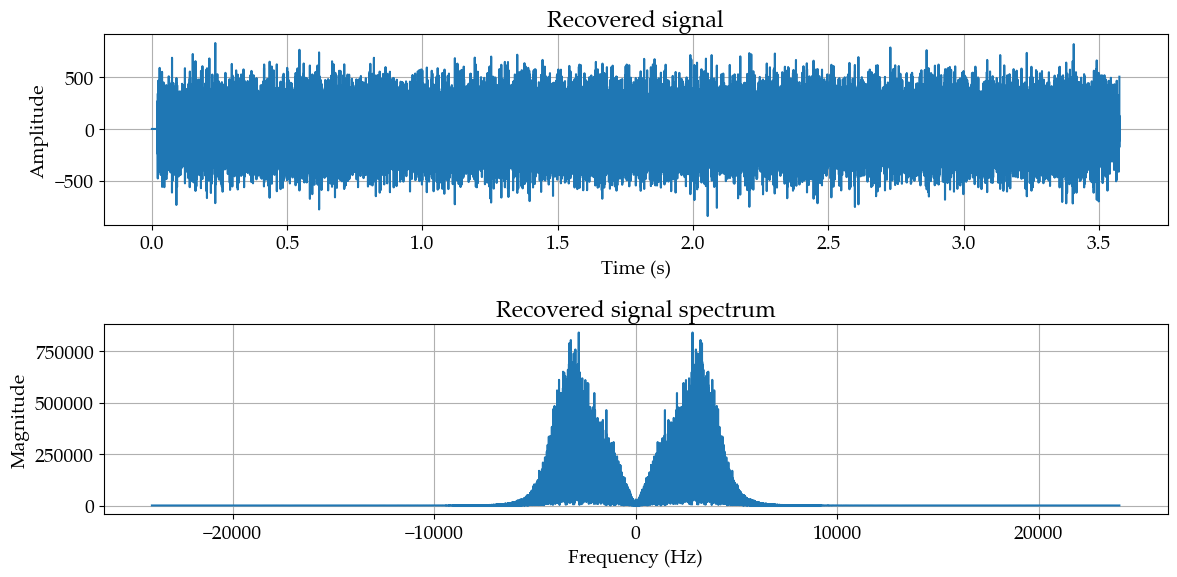

In [52]:
# recover the signal
output_signal = np.abs(np.fft.ifft(detected_spectrum_post_filter))
output_signal_nodc = output_signal - np.mean(output_signal)
output_signal_nodc = output_signal_nodc / np.max(np.abs(output_signal_nodc)) * np.max(np.abs(orig_data))
# plot recovered signal
output_signal_nodc[0:1000] = 0
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, output_signal_nodc)
plt.title('Recovered signal')
plt.xlabel('Time (s)')
# plt.xlim(0,0.01)
plt.ylabel('Amplitude')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(freqs, np.abs(fftshift(fft(output_signal_nodc))))
plt.title('Recovered signal spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.tight_layout()
plt.show()

# write recovered signal to wav
wavfile.write('audio_recovered.wav', fs, output_signal_nodc.astype(np.int16))


In [19]:
# Calculate SNR for FM signals
def snr_fm(signal, noise, fs):
    """ Calculate Signal-to-Noise Ratio (SNR) for FM signals """
    signal_power = np.var(signal)
    noise_power = np.var(noise)
    return 10 * np.log10(signal_power / noise_power)

# Pre-detection SNR for FM
pre_detection_snr_fm = snr_fm(fm_signal, noise, fs)

# Post-detection SNR for FM (after low-pass filtering)
post_detection_snr_fm = snr_fm(filtered_demodulated_signal, noise, fs)

pre_detection_snr_fm, post_detection_snr_fm

(16.977781295052317, 61.87870551592735)